In [ ]:
!pip install keras_tuner==1.1.0

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import utils

from sklearn.preprocessing import OneHotEncoder


In [ ]:
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
df_monk1_train = pd.read_csv("./data/MONK/monks-1.train", sep = " ", skipinitialspace=True, names = colnames)
df_monk1_train.drop('id', axis = 1, inplace = True)
df_monk1_test = pd.read_csv("./data/MONK/monks-1.test", sep = " ", skipinitialspace=True, names = colnames)
df_monk1_test.drop('id', axis = 1, inplace = True)
df_monk1_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [ ]:
#subdivide data in training, validation and test set 
X_all = df_monk1_train.iloc[:, 1:7].values
y_all = df_monk1_train.iloc[:, 0].values
val_size =int(0.2 * len(X_all))
#X_val = X_all[:val_size]
y_val = y_all[:val_size]
X_train = X_all[val_size:]
y_train = y_all[val_size:]
X_test = df_monk1_test.iloc[:, 1:7].values
y_test = df_monk1_test.iloc[:, 0].values


# One hot encoding 

In [ ]:

enc_all = OneHotEncoder()
enc_all.fit(X_all)
X_all = enc_all.transform(X_all).toarray()
print(X_all[0])

X_val = X_all[:val_size]
print(X_val.shape)

X_train = X_all[val_size:]
print(X_train.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test)
X_test = enc_test.transform(X_test).toarray()
print(X_test.shape)
print(X_all[0].shape)
'''X_all = utils.to_categorical(X_all)
print(X_all[0])
one_hot_test = utils.to_categorical(X_test)
X_train = X_all[val_size:]
X_val = X_all[:val_size]
print(X_train.shape)
print(X_val.shape)
X_test = one_hot_test 
print(X_test.shape)'''
print(X_train[0])
print(X_train[1])

[1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
(24, 17)
(100, 17)
(432, 17)
(17,)
[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]


In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        #model.add(layers.Dense(units=hp.Int('units1', min_value=6, max_value=72, step=6), activation='relu'))
        #model.add(layers.Flatten(input_shape=(17,)))
        model.add(layers.Dense(units=hp.Int('units', min_value=6, max_value=72, step=2), activation='relu', input_shape=(17,)))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    def fit(self, hp, model, X, y, validation_data=None, **kwargs):
        if validation_data:
            X_val, y_val = validation_data
        return model.fit(X, y, shuffle=True, validation_data=validation_data, **kwargs)


In [ ]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=5,
    overwrite=True,
)
tuner.search_space_summary()


Search space summary
Default search space size: 1
units (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 72, 'step': 2, 'sampling': None}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=150, batch_size=10, callbacks=[stop_early], verbose=0,  validation_data=(X_val, y_val) )
hypermodel = MyHyperModel()
hyperparameters = tuner.get_best_hyperparameters()[0]
model = hypermodel.build(hyperparameters)
print(hyperparameters.get('units'))
print(model.summary())
#print(hyperparameters.get('units2'))
#print(hyperparameters.get('learning_rate'))



INFO:tensorflow:Oracle triggered exit
66
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 66)                1188      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 67        
Total params: 1,255
Trainable params: 1,255
Non-trainable params: 0
_________________________________________________________________
None


[1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
1
14/14 [==============================] - 0s 816us/step - loss: 0.2589 - accuracy: 0.9120


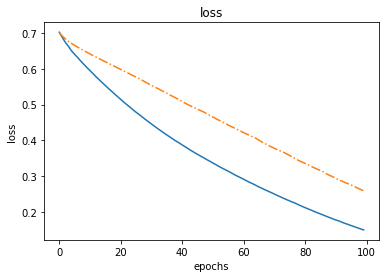

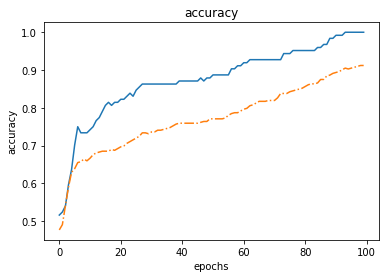

In [ ]:
train_loss = []
test_loss =[]
train_acc = []
test_acc = []

print(X_all[0])
print(y_all[0])

for i in range(100):
    history = hypermodel.fit(hyperparameters, model, X_all, y_all, verbose=0)
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    score = model.evaluate(X_test, y_test)
    test_loss.append(score[0])
    test_acc.append(score[1])

plt.plot(train_loss, '-')
plt.plot(test_loss, '-.')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.plot(train_acc, '-')
plt.plot(test_acc, '-.')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>